In [1]:
import numpy as np                        # For linear algebra
import cvxpy as cp
import matplotlib.pyplot as plt            # For plots
from scipy.signal import ss2tf
# np.random.seed(1)                          # Generate random seed
# np.set_printoptions(precision=1)           # Set nice printing format

Plan:
1. Write a state space system and calcualte the transfer function
2. compute L gap using SVD
3. compute L gap with different Hankel matrix length L
4. compute v gap using transfer function
5. Compare between the two values: Fix one system and vary the other to calculate multiple annd plot value vs. delta

In [3]:
#1. Generate random system

def is_controllable(A, B, tol=1e-9):
    """
    Check controllability of (A,B) using the controllability matrix:
        C = [B, AB, A^2 B, ..., A^{n-1} B]
    """
    n = A.shape[0]
    C = B
    for _ in range(1, n):
        C = np.hstack((C, A @ C[:, -B.shape[1]:]))
    rank = np.linalg.matrix_rank(C, tol=tol)
    return rank == n

def is_observable(A, C, tol=1e-9):
    """
    Check observability of (A,C) using the observability matrix:
        O = [C; CA; CA^2; ...; CA^{n-1}]
    """
    n = A.shape[0]
    O = C
    for _ in range(1, n):
        O = np.vstack((O, O[-C.shape[0]:, :] @ A))
    rank = np.linalg.matrix_rank(O, tol=tol)
    return rank == n

def random_discrete_system(n=2, m=1, p=1, max_tries=1000, scale_A=1.0):
    """
    Generate a random discrete-time state-space system:
        x_{k+1} = A x_k + B u_k
        y_k     = C x_k + D u_k

    such that (A,B) is controllable and (A,C) is observable.

    n : number of states
    m : number of inputs
    p : number of outputs
    max_tries : how many random draws before giving up
    scale_A : multiply A by this factor (you can <1.0 to make it "more stable"
    """
    for _ in range(max_tries):
        A = scale_A * np.random.randn(n, n)
        B = np.random.randn(n, m)
        C = np.random.randn(p, n)
        D = np.zeros((p, m))  # often we take D = 0

        if is_controllable(A, B) and is_observable(A, C):
            return A, B, C, D

    raise RuntimeError("Failed to find controllable & observable system in max_tries.")

def ss_to_tf_discrete(A, B, C, D):
    """
    Compute discrete-time transfer function G(z) from (A,B,C,D).

    Returns:
        num: array of numerator coefficient arrays, shape (p, m), each entry is 1D ndarray
        den: 1D ndarray of denominator coefficients (same for all I/O pairs)
    """
    p, m = D.shape
    num = np.empty((p, m), dtype=object)
    den = None

    for j in range(m):
        # ss2tf returns numerator(s) for all outputs for input j
        num_j, den_j = ss2tf(A, B, C, D, input=j)
        if den is None:
            den = den_j
        for i in range(p):
            num[i, j] = num_j[i, :]

    return num, den

# if __name__ == "__main__":
#     np.random.seed(0)

#     # 3-state, SISO, discrete-time, controllable & observable
#     A, B, C, D = random_discrete_system(n=3, m=1, p=1)

#     print("A =\n", A)
#     print("B =\n", B)
#     print("C =\n", C)
#     print("D =\n", D)

#     num, den = ss_to_tf_discrete(A, B, C, D)

#     num_siso = num[0, 0]
#     print("\nDiscrete-time transfer function G(z):")
#     print("Numerator coefficients:", num_siso)
#     print("Denominator coefficients:", den)

#     # You can build a poly1d if you like:
#     z_num = np.poly1d(num_siso)
#     z_den = np.poly1d(den)
#     print("\nG(x) = (", z_num, " ) / (", z_den, ")")


In [4]:
#1.2 Generate Hankel matrix
def persistently_exciting_input(T, m=1, std=1.0):
    """
    Generate persistently exciting input (white noise).
    m = number of inputs
    T = length
    """
    return np.random.randn(T, m) * std

def simulate_system(A, B, C, D, u, x0=None):
    """
    Simulate x_{k+1} = A x_k + B u_k,  y_k = C x_k + D u_k

    u : array (T, m)
    """
    A = np.asarray(A); B = np.asarray(B)
    C = np.asarray(C); D = np.asarray(D)

    T, m = u.shape
    n = A.shape[0]
    p = C.shape[0]

    if x0 is None:
        x0 = np.zeros((n, 1))

    x = np.zeros((T+1, n))
    y = np.zeros((T, p))

    x[0] = x0[:,0]

    for k in range(T):
        x[k+1] = A @ x[k] + B @ u[k]
        y[k]   = C @ x[k] + D @ u[k]

    return x, y

def hankel_matrix(data, L):
    """
    Build a Hankel matrix of depth L from a 1D or vector sequence.

    data: array (T, d)  → T time steps, d-dimensional signal (e.g. input or output)
    L: depth
    Returns H ∈ R^{L*d × (T-L+1)}
    """
    data = np.asarray(data)
    T, d = data.shape
    cols = T - L + 1
    H = np.zeros((L*d, cols))
    for i in range(L):
        H[i*d:(i+1)*d, :] = data[i:i+cols].T
    return H

# Example usage
# if __name__ == "__main__":
#     np.random.seed(1)

#     # Generate random system
#     A, B, C, D = random_discrete_system(n=3, m=1, p=1, scale_A=0.5)

#     # Generate persistently exciting input
#     T = 50
#     u = persistently_exciting_input(T, m=1, std=1.0)

#     # Simulate system
#     x, y = simulate_system(A, B, C, D, u)

#     # Build Hankel matrices
#     L = 10  # depth
#     H_u = hankel_matrix(u, L)
#     H_y = hankel_matrix(y, L)

#     print("Hankel matrix of inputs H_u shape:", H_u.shape)
#     print("Hankel matrix of outputs H_y shape:", H_y.shape)


In [35]:
#2.1 Generate two systems
# Generate random system
A1, B1, C1, D1 = random_discrete_system(n=2, m=1, p=1, scale_A=0.5)
A2, B2, C2, D2 = random_discrete_system(n=2, m=1, p=1, scale_A=0.5)
print("A1 =\n", A1)
print("A2 =\n", A2)
print("B1 =\n", B1)
print("B2 =\n", B2)

A1 =
 [[-0.59447248  0.38662649]
 [-0.59194032 -1.32958612]]
A2 =
 [[ 0.8297754   0.5342547 ]
 [-0.2266929  -0.34391881]]
B1 =
 [[ 0.60631952]
 [-1.75589058]]
B2 =
 [[-1.2140774 ]
 [-0.44092263]]


In [41]:
#2.2 Simulate both systems and build Hankel matrices
# Generate persistently exciting input
T = 50
u = persistently_exciting_input(T, m=1, std=1.0)
# Simulate system 1
x1, y1 = simulate_system(A1, B1, C1, D1, u)
# Simulate system 2
x2, y2 = simulate_system(A2, B2, C2, D2, u)
# A1[0,0] = A2[0,0]  #make systems more similar
# x2, y2 = simulate_system(A1, B1, C1, D1, u)

# Build Hankel matrices
L = 30  # depth
H_u = hankel_matrix(u, L)
H_y1 = hankel_matrix(y1, L)
H_y2 = hankel_matrix(y2, L)

# print("Hankel matrix of inputs H_u:", H_u)
# print("Hankel matrix of outputs H_y1:", H_y1)
# print("Hankel matrix of outputs H_y2:", H_y2)

In [42]:
#2.3 principal angles
# Guide for principal angle code https://pyphysim.readthedocs.io/en/latest/_modules/pyphysim/subspace/metrics.html
def principal_angles(H1, H2, return_degrees=False):
    """Compute principal angles between subspaces span(H1) and span(H2).

    H1: (n, p) matrix whose columns span first subspace
    H2: (n, q) matrix whose columns span second subspace
    return_degrees: if True, return angles in degrees instead of radians

    Returns:
        angles: array of principal angles (length = min(rank(H1), rank(H2)))
    """

    # Orthonormal bases via QR
    Q1 = np.linalg.qr(H1)[0]
    Q2 = np.linalg.qr(H2)[0]
    # SVD of Q1^T Q2
    M = Q1.conjugate().transpose().dot(Q2)
    S= np.linalg.svd(M, full_matrices=False)[1]
    # print("Singular values:", S)

    # Clip numerical noise into [-1,1] then take arccos
    S = np.clip(S, -1.0, 1.0)
    # S[S > 1] = 1
    angles = np.arccos(S)  # radians, between 0 and pi/2
    # print("Principal angles (radians):", angles)
    if return_degrees:
        angles = angles * 180 / np.pi

    return angles  # sorted from smallest to largest

def Lgap_metric(A, B):
    """
    Compute gap(U,V) for subspaces U=span(A), V=span(B),
    assuming dim(U) = dim(V) and both have the same rank.

    Returns:
        gap_value, theta_max (in radians)
    """
    angles = principal_angles(A, B)

    # largest principal angle
    theta_max = np.max(angles)

    # gap = sin(theta_max)  (for equal dimensions)
    gap_value = np.sin(theta_max)

    return gap_value, theta_max

gap_value, theta_max = Lgap_metric(H_y1, H_y2)
print("Gap metric:", gap_value)
print("Largest principal angle (degrees):", theta_max * 180 / np.pi)

Gap metric: 0.9998795133987503
Largest principal angle (degrees): 89.11057083172348


In [32]:
# 2.4 L gap using remark 3. L-gap = 2-norm(U_2T U1)

def hankel_svd_blocks(H, l=None, tol=1e-9):
    """
    SVD block decomposition for a Hankel matrix H, as in:
        H = [U1 U2] [[S 0],[0 0]] [V1^T; V2^T]

    Args
    ----
    H : array_like, shape (N, T)
        Hankel matrix (columns = time shifts).
    l : int or None
        Dimension of the behavior subspace (number of "nonzero" singular values).
        If None, it is inferred as the numerical rank (s > tol).
    tol : float
        Tolerance for deciding numerical rank.

    Returns
    -------
    U1 : ndarray, shape (N, l)
        Left singular vectors spanning the column space of H.
    U2 : ndarray, shape (N, N-l)
        Left singular vectors spanning the orthogonal complement.
    S  : ndarray, shape (l, l)
        Diagonal matrix of the l largest singular values.
    V1 : ndarray, shape (T, l)
        Right singular vectors corresponding to S.
    V2 : ndarray, shape (T, T-l)
        Remaining right singular vectors (orthogonal complement).
    """
    H = np.asarray(H, dtype=float)

    # Full SVD
    U, s, Vt = np.linalg.svd(H, full_matrices=True)

    # # Decide "behavior dimension" l
    # if l is None:
    #     l = int(np.sum(s > tol))

    # Split left singular vectors
    U1 = U[:, :l]          # N x l
    U2 = U[:, l:]          # N x (N-l)

    # Singular values block
    S = np.diag(s[:l])     # l x l

    # Split right singular vectors (remember Vt = V^T)
    V1 = Vt[:l, :].T       # T x l
    V2 = Vt[l:, :].T       # T x (T-l)

    return U1, U2, S, V1, V2


def Lgap_metric2(H1, H2, m, n, L, use_alt_formula=True, tol=1e-9):
    """
    Compute the L-gap between two behaviors, from their Hankel matrices H1, H2.

    H1, H2 : array_like
        Flattened Hankel matrices H_L(w^d) and H_L(ŵ^d).
        Their row-dimension should correspond to L blocks of (u,y) stacked.
    m : int
        Number of inputs.
    n : int
        State dimension.
    L : int
        Horizon used in the block Hankel (must satisfy L > l/m ?; in paper, L > something).
    use_alt_formula : bool
        If True, use ||U2^T \tilde U1||_2.
        If False, use ||U1 U1^T - \tilde U1 \tilde U1^T||_2.
    """
    # Behavior dimension from theory:
    l = m * L + n

    # Block SVD decompositions
    U1, U2, _, _, _ = hankel_svd_blocks(H1, l=l, tol=tol)
    U1_t, U2_t, _, _, _ = hankel_svd_blocks(H2, l=l, tol=tol)

    if use_alt_formula:
        # gap_L = ||U2^T * U1_t||_2
        M = U2_t.T @ U1
        # spectral norm = largest singular value
        # svals = np.linalg.svd(M, compute_uv=False)
        # gap = svals[0] if svals.size > 0 else 0.0
        gap = np.linalg.norm(M, 2)
    else:
        # gap_L = ||U1 U1^T - U1_t U1_t^T||_2
        P1 = U1 @ U1.T
        P2 = U1_t @ U1_t.T
        M = P1 - P2
        svals = np.linalg.svd(M, compute_uv=False)
        gap = svals[0] if svals.size > 0 else 0.0

    return gap
m = 1      # number of inputs
n = 2      # state dimension
L = 20     # block horizon used to build the Hankels

gap_L = Lgap_metric2(H_y1, H_y2, m, n, L)
print("L-gap =", gap_L)

L-gap = 0.9999999049100083


L-gap = 0.0


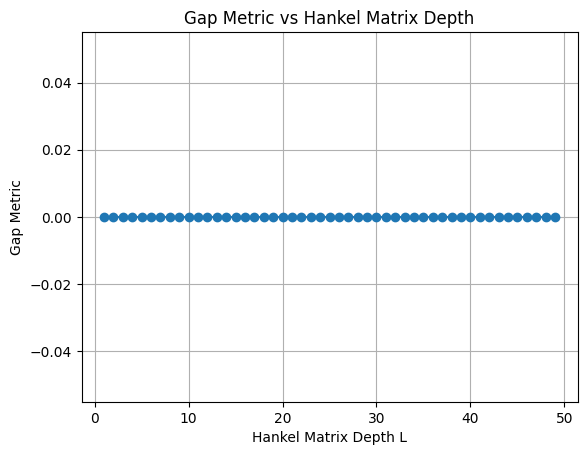

In [23]:
#3.1
#build Hankel matrices with different depth L and compute gap
Ls = range(1, 50)
# print(list(Ls))
gap_values = []
for L in Ls:
    H_y1 = hankel_matrix(y1, L)
    H_y2 = hankel_matrix(y2, L)
    gap_value = Lgap_metric2(H_y1, H_y2, m, n, L)
    gap_values.append(gap_value)
H_y1 = hankel_matrix(y1, 30)
H_y2 = hankel_matrix(y2, 30)
gap_L = Lgap_metric2(H_y1, H_y2, m, n, 20)
print("L-gap =", gap_L)
#plotting gap vs L
plt.figure()
plt.plot(Ls, gap_values, marker='o')
plt.xlabel('Hankel Matrix Depth L')
plt.ylabel('Gap Metric')
plt.title('Gap Metric vs Hankel Matrix Depth')
plt.grid()
plt.show()

LQR Gain K0: [[-0.23806055 -0.56654123]]


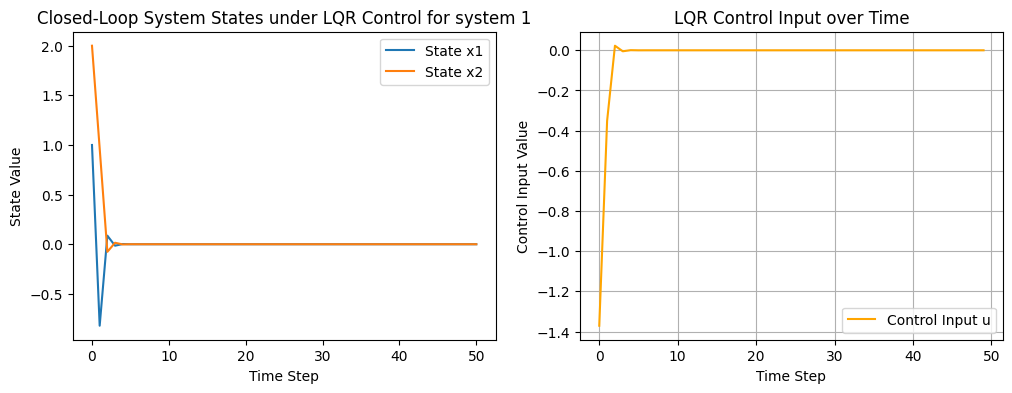

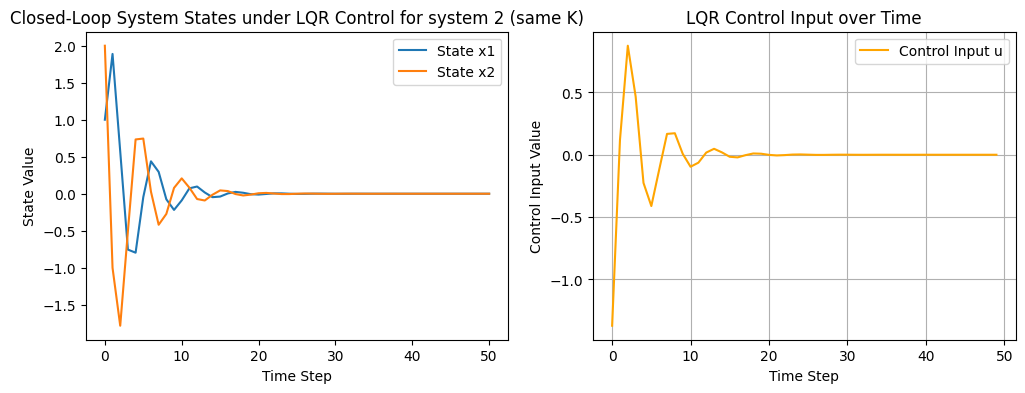

In [82]:
#2.5 test whether the same controller can be used for both systems
#LQR controller
Q = np.eye(2)
# Q[1,1] = 0 #get rid of x2 penalty
R = np.eye(1)*0.1
def lqr(Q, R, A, B, N):
    P = [None]*(N+1); P[N] = Q
    for k in range(N-1, -1, -1):
        S = R + B.T @ P[k+1] @ B
        Kk = np.linalg.solve(S, B.T @ P[k+1] @ A)
        P[k] = Q + A.T @ (P[k+1] - P[k+1] @ B @ np.linalg.solve(S, B.T @ P[k+1])) @ A
    # use stage-0 gain:
    S0 = R + B.T @ P[1] @ B
    K0 = np.linalg.solve(S0, B.T @ P[1] @ A)
    print("LQR Gain K0:", K0)
    return K0


# simulate closed loop system. Assumed using system 1 where A is a 2x2 matrix
N = 50 #number of control steps
x0 = np.array([[1],[2]]) #initial state
x_cl = np.zeros((N+1, x0.shape[0], x0.shape[1]))
x_cl[0, :, :] = x0 #initial state
xf = np.array([[0],[0]]) #desired state
u_cl = np.zeros((N, R.shape[0], 1))
K_control = lqr(Q, R, A1, B1, 10)
for k in range(N):
    u_control = -K_control @ (x_cl[k] - xf)
    x_cl[k+1] = A1 @ x_cl[k] + B1 @ u_control
    u_cl[k] = u_control

# Plot results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(x_cl[:,0,0], label='State x1')
plt.plot(x_cl[:,1,0], label='State x2')
plt.title('Closed-Loop System States under LQR Control for system 1')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(N), -u_cl[:,0,0], label='Control Input u', color='orange')
plt.title('LQR Control Input over Time')
plt.xlabel('Time Step')
plt.ylabel('Control Input Value')
plt.legend()
plt.grid()
plt.show()

#use same controller on system 2
for k in range(N):
    u_control = -K_control @ (x_cl[k] - xf)
    x_cl[k+1] = A2 @ x_cl[k] + B2 @ u_control
    u_cl[k] = u_control

# Plot results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(x_cl[:,0,0], label='State x1')
plt.plot(x_cl[:,1,0], label='State x2')
plt.title('Closed-Loop System States under LQR Control for system 2 (same K)')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(N), -u_cl[:,0,0], label='Control Input u', color='orange')
plt.title('LQR Control Input over Time')
plt.xlabel('Time Step')
plt.ylabel('Control Input Value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#4.1 Find transfer function of both systems
num1, den1 = ss_to_tf_discrete(A1, B1, C1, D1)
num2, den2 = ss_to_tf_discrete(A2, B2, C2, D2)
z_num1 = np.poly1d(num1[0,0])
z_den1 = np.poly1d(den1)
print("\nG1(s) = (", z_num1, " ) / (", z_den1, ")")
z_num2 = np.poly1d(num2[0,0])
z_den2 = np.poly1d(den2)
print("\nG2(s) = (", z_num2, " ) / (", z_den2, ")")

#4.2 Find v-gap


G(x) = (  
0.4734 x - 0.5362  ) / (    2
1 x - 1.055 x - 0.4713 )

G(x) = (  
0.5798 x + 0.3328  ) / (    2
1 x - 0.285 x + 0.0925 )
